                    Download and import some packages

In [3]:
!pip install transformers

     |████████████████████████████████| 674 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 8.6 MB/s eta 0:00:01     |███████████████████████▊        | 4.2 MB 8.6 MB/s eta 0:00:01     |███████████████████████████▏    | 4.8 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 24.2 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=498eba5ca496903776cac634d265269ec8f43668588d45bfb9d8767c798bc800
  Stored in directory: /home/qb/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

            PART ONE: Using BERT for text classification
    Import the dataset

In [5]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

In [6]:
batch_1 = df[:2000] #Performance issues
batch_1[1].value_counts() #1 >> Positive 0 >> Neative

1    1041
0     959
Name: 1, dtype: int64

    Load Pre-trained BERT

In [7]:
# For DistilBERT: << Smaller faster and uses less memory
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? 
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

        1.Prepare the dataset

In [14]:
# ------ Tokenization

tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens = True)))

# --- tokenized >> A list of indexes of varied length sentences

In [17]:
# ------ Padding

max_len = max([len(i) for i in tokenized.values])

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# --- padded >> An ndarray of sentences of max_len length

In [23]:
# ------- Masking __So BERT ignores the padding when processing

attention_mask = np.where(padded != 0,
                         1,
                         0) 
# np.where(condition, [x,y] >> Return element chosen from x ,y depending on condition i.e if condition return x else y

In [25]:
# -------- DEEP LEARNING with our model

input_idx = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_state = model(input_idx, attention_mask = attention_mask)

            How does bert do sentence classification?
_It adds a token called CLS at the beginning of every sentence_ \
BERT output is 3-dimensional for row, positions in each sequence, number of hidden layers.\
But we need just the CLS column

In [28]:
features = last_hidden_state[0][:,0,:].numpy()

# --- features >> CLS column

In [31]:
labels = batch_1[1]

# labels >> batch_1 labels(1) column

    2. Train-Test Split

In [32]:
train_features, test_features, train_labels, test_labels =  train_test_split(features,labels)

        2.i. Train Logistic Regression model

In [33]:
lr_cls = LogisticRegression()
lr_cls.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

        2.ii. Evaluate model

In [34]:
lr_cls.score(test_features, test_labels)

0.832

In [38]:
from sklearn.dummy import DummyClassifier

cls = DummyClassifier()

scores = cross_val_score(cls, train_features, train_labels)
print("Dummy classifier scores: %0.3f (+/- %0.2f)" %(scores.mean(), scores.std()*2))

Dummy classifier scores: 0.483 (+/- 0.07)


        Redo HW1

In [39]:
# Loading data
try:
    data = pd.read_csv('./datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [40]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [41]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

In [42]:
texts_train_tokenized = [tokenizer.encode(x, max_length=512, add_special_tokens=True) for x in texts_train]
texts_test_tokenized = [tokenizer.encode(x, max_length=512, add_special_tokens=True) for x in texts_test] 

In [43]:
def pad_texts(texts_tokenized):
    max_len = 0
    for i in texts_tokenized:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in texts_tokenized])
    return padded

In [44]:
padded_train = pad_texts(texts_train_tokenized)
padded_test = pad_texts(texts_test_tokenized)

In [45]:
def attention_mask(padded_text):
    return np.where(padded_text != 0, 1, 0)

In [46]:
attention_mask_train = attention_mask(padded_train)
attention_mask_train.shape

(500, 512)

In [47]:
attention_mask_test = attention_mask(padded_test)
attention_mask_test.shape

(500, 512)

    Move the model to gpu and check if it is in eval mode

In [48]:
model = model_class.from_pretrained(pretrained_weights)

In [49]:
device = torch.device('cuda: 0') if torch.cuda.is_available() else torch.device('cpu')

In [50]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [54]:
import tqdm

output_train = []
batch_size = 22

for idx in tqdm.tnrange(0, len(padded_train), batch_size):
    batch = torch.tensor(padded_train[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_train[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_state = model(batch, attention_mask = local_attention_mask)[0][:,0,:].cpu().numpy()
        output_train.append(last_hidden_state)

In [56]:
output_test = []
batch_size = 22

for idx in tqdm.tnrange(0, len(padded_train), batch_size):
    batch = torch.tensor(padded_train[idx:idx+batch_size]).to(device)
    local_attention_mask = torch.tensor(attention_mask_train[idx:idx+batch_size]).to(device)
    
    with torch.no_grad():
        last_hidden_state = model(batch, attention_mask = local_attention_mask)[0][:,0,:].cpu().numpy()
        output_test.append(last_hidden_state)

In [57]:
train_features = np.vstack(output_train)
test_features  = np.vstack(output_test)

In [59]:
new_lr_cls = LogisticRegression()

new_lr_cls.fit(train_features, y_train)
new_lr_cls.score(test_features, y_test)

0.498

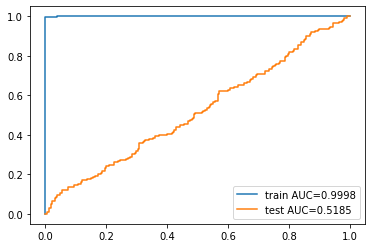

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

proba = new_lr_cls.predict_proba(train_features)[:, 1]
auc = roc_auc_score(y_train, proba)
plt.plot(*roc_curve(y_train, proba)[:2], label='%s AUC=%.4f' % ('train', auc))

proba = new_lr_cls.predict_proba(test_features)[:, 1]
auc = roc_auc_score(y_test, proba)
plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC=%.4f' % ('test', auc))
plt.legend()